#  how does NormalMixture work?

In [1]:
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
import pymc3 as mc
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import tqdm
import pandas as pd

%matplotlib inline

%load_ext version_information

%version_information pymc3, scipy



Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
pymc3 3.1
scipy 0.19.1
Wed Sep 20 18:40:48 2017 MDT

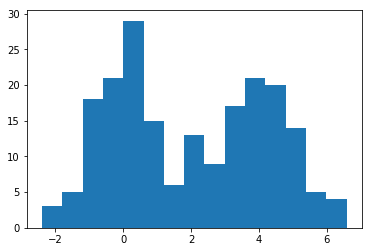

In [2]:
np.random.seed(8675309)
x = stats.norm.rvs(loc=0, scale=1, size=100)
x = np.append(x, stats.norm.rvs(loc=4, scale=1, size=100))
plt.hist(x, 15, normed=False);


# Do this in pymc3

In [15]:
model = Model()
with model:
    # Priors are posterior from previous iteration
    means = mc.Uniform('means', -10, 10, shape=2)
    weights = mc.Uniform('weights', 0, 1, shape=2)
    sds=
    dat = mc.NormalMixture

    # draw 10000 posterior samples
    trace = sample(10000)


Optimization terminated successfully.
         Current function value: 455.810227
         Iterations: 12
         Function evaluations: 18
         Gradient evaluations: 18


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 604.67: 100%|██████████| 10000/10000 [00:01<00:00, 6372.00it/s]
Finished [100%]: Average Loss = 604.48
100%|██████████| 2000/2000 [00:26<00:00, 75.51it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1257834e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121babbe0>]], dtype=object)

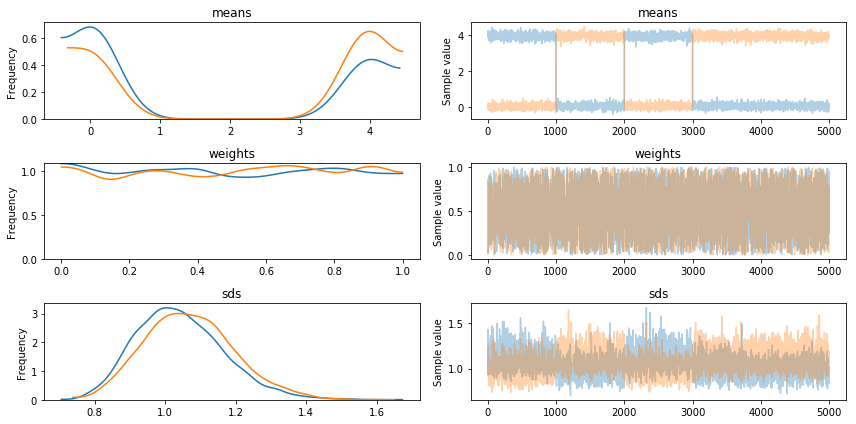

In [16]:
traceplot(trace, combined=True)

In [27]:
ppc = mc.sample_ppc(trace, samples=5000, model=model, vars='dat')


  0%|          | 0/5000 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'distribution'

## Can we do this manually?

In [62]:
model = Model()
with model:
    # Priors are posterior from previous iteration
    mean1 = mc.Uniform('mean1', [-10, -10], [10, 10], shape=2)
    #     mean2 = mc.Uniform('mean2', -10, 10)
    #     weight1 = mc.Uniform('weight1', 0, 1)
    #     weight2 = mc.Uniform('weight2', 0, 1)
    sd1 = mc.Uniform('sd1', [0,0], [100,100], shape=2)
    #     sd2 = mc.Uniform('sd2', 0, 100)
#     norm1 = mc.Normal('norm1', mu=mean1, sd=sd1)
#     norm2 = mc.Normal('norm2', mu=mean2, sd=sd2)

    dat = mc.Normal('dat', mu=mean1, sd=sd1, observed=x)

    # draw 10000 posterior samples
    start = mc.find_MAP()
    trace = mc.sample(1000, start=start, njobs=5, n_init=10000, tune=1000)

ValueError: Input dimension mis-match. (input[0].shape[0] = 200, input[1].shape[0] = 2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e65af60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12f7516d8>]], dtype=object)

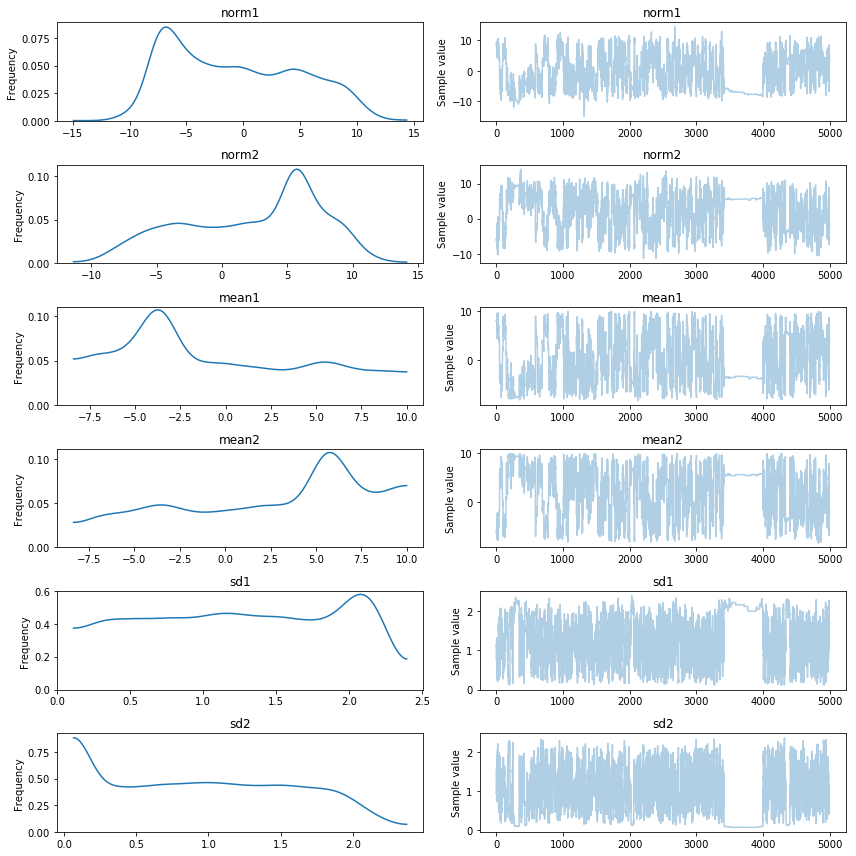

In [36]:
traceplot(trace, combined=True)

##  Follow http://docs.pymc.io/notebooks/gaussian_mixture_model.html

In [56]:

# setup model
model = mc.Model()
with model:
    # cluster sizes
#     p = mc.Dirichlet('p', a=np.array([1., 1.]), shape=2)
    p = mc.Uniform('p', [0,0], [1,1], shape=2)
    # ensure all clusters have some points
    p_min_potential = mc.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = mc.Normal('means', mu=[0, 0], sd=15, shape=2)
    # break symmetry
    order_means_potential = mc.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0))

    # measurement error
    sd = mc.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = mc.Categorical('category',
                              p=p,
                              shape=len(x))

    # likelihood for each observed value
    points = mc.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=x)

In [57]:
with model:
     # draw 10000 posterior samples
    start = mc.find_MAP()
    trace = mc.sample(4000, start=start, njobs=5, n_init=10000, tune=1000)

         Current function value: 803.168733
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3


Assigned NUTS to p_interval__
Assigned NUTS to means
Assigned NUTS to sd_interval__
Assigned BinaryGibbsMetropolis to category
 97%|█████████▋| 4868/5000 [05:23<00:08, 15.56it/s]/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 1 contains 98 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 98%|█████████▊| 4893/5000 [05:25<00:06, 17.70it/s]/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 2 contains 97 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 98%|█████████▊| 4912/5000 [05:26<00:04, 20.25it/s]/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 4 contains 120 diverging samples after tuning. If incre

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134304128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12eaf1b38>]], dtype=object)

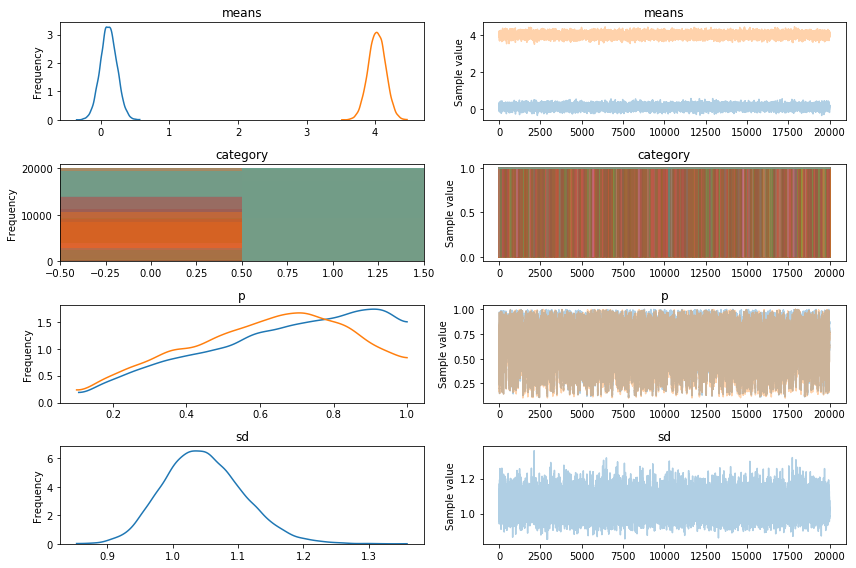

In [58]:
traceplot(trace, combined=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133013d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1369722e8>]], dtype=object)

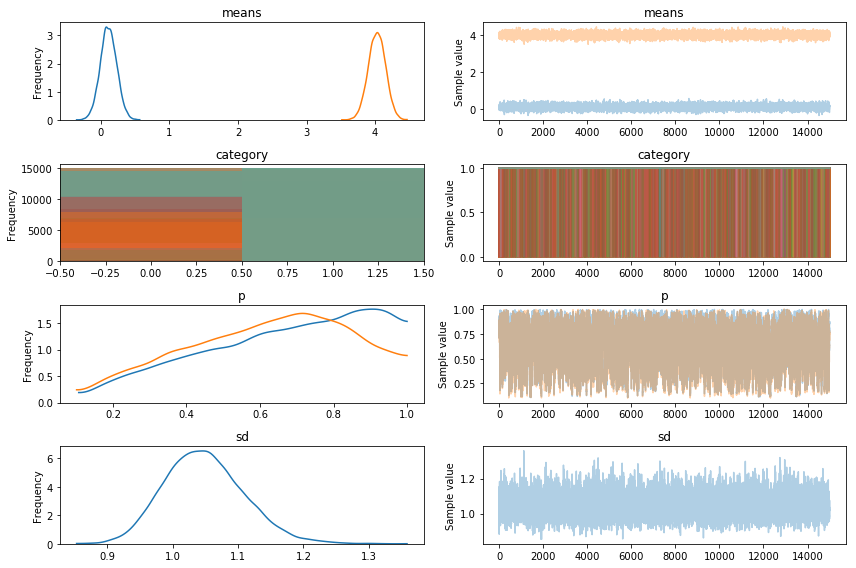

In [59]:
traceplot(trace[1000:], combined=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136412ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15907c8d0>]], dtype=object)

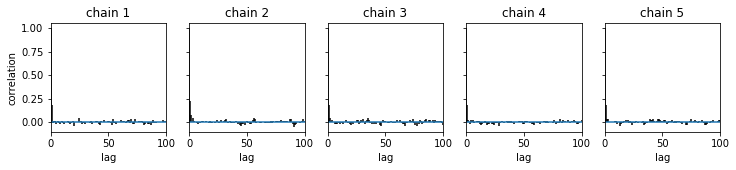

In [60]:
mc.autocorrplot(trace[:], varnames=['sd'])


In [61]:
mc.summary(trace)


means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.111            0.119            0.001            [-0.126, 0.341]
  4.025            0.125            0.001            [3.787, 4.273]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.122         0.032          0.110          0.191          0.348
  3.779          3.941          4.025          4.110          4.268


category:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.006            0.077            0.001            [0.000, 0.000]
  0.010            0.100            0.001            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.010            0.000            [0.0